In [1]:
import numpy as np
import numpy.ma as ma

import corner

import matplotlib.pyplot as plt
#%matplotlib notebook

import emcee

import sys
sys.path.insert(1, '/Users/richardzhang/Documents/UR_Stuff/Research_UR/RotationCurve/2D_RC/main/')
#sys.path.insert(1, '/Users/kellydouglass/Documents/Research/Rotation_curves/Yifan_Zhang/RotationCurve/2D_RC/main/')
from RC_2D_Fit_Functions import Galaxy_Data, getTidal
from Velocity_Map_Functions_cython import rot_incl_iso, rot_incl_NFW, rot_incl_bur

from Velocity_Map_Functions import loglikelihood_iso_flat,\
                                   loglikelihood_NFW_flat,\
                                   loglikelihood_bur_flat,\
                                   loglikelihood_iso_flat_constraints,\
                                   loglikelihood_NFW_flat_constraints,\
                                   loglikelihood_bur_flat_constraints

In [2]:
scale = 0.186561705

In [3]:
initial_guesses_7495_12704 = [-1, 1, 1000, 4, -3, 25, 0.7210909552087809, 4.147748787425744, 32, 32, 0]

model_guesses_7495_12704 = [-1, 1, 1000, 4, -3, 25]

geo_guesses_7495_12704 =  [0.7210909552087809, 4.147748787425744, 32, 32, 0]

# Isothermal Random

In [4]:
'''
mini_soln_iso = [np.log10(11.66291723), 
                 2.69E-05, 
                 1031.023329,
                 1.838768634,
                 0.083546044,
                 0.102759719,
                 0.553854733,
                 1.951500683,
                 26.37172472,
                 27.44266793,
                 0.907424538]

mini_soln_iso = [10**-1.75945524e+00,
             9.92569881e-01,  
             1.53473087e+03,  
             1.53193786e+00,
             10**-9.71730256e-01,  
             2.21049991e+00,  
             4.00380847e-01,  
             1.96012236e+00,
             2.65844368e+01,  
             2.76934251e+01, 
             -9.79924775e-01]

mini_soln_iso = [7.66264388e-01, # log space
             4.28494430e-04, 
             7.03244006e+02, 
             2.12860812e+00,
             5.51777291e-01, # linear space 
             6.18380443e-01, 
             5.03198402e-01, 
             1.95476738e+00,
             2.63520188e+01, 
             2.75923933e+01, 
             5.36541119e-01]
''';
mini_soln_iso = [0.402061622,
                 2.904989162,
                 2999.999944,
                 15.2989453,
                 0.809847042,
                 1.132706912,
                 0.129201107,
                 4.265775688,
                 32.28859267,
                 32.7749669,
                 -3.911399739]

In [5]:
labels = [r'log($\rho_b$)', 
          r'$R_b$', 
          r'$\Sigma_d$', 
          r'$R_d$',
          r'$\rho_h$', #'log($\rho_h$)',
          r'$R_h$',
          'i',
          r'$\phi$',
          'x',
          'y',
          r'$V_{sys}$']

In [7]:
from mapSmoothness_functions import how_smooth
import os.path
from os import path

MANGA_FOLDER = '/Users/richardzhang/Documents/UR_Stuff/Research_UR/SDSS/dr16/manga/spectro/'
#MANGDA_FOLDER = '/home/yzh250/Documents/UR_Stuff/Research_UR/SDSS/dr16/manga/spectro/'
#MANGA_FOLDER = '/Users/kellydouglass/Documents/Research/data/SDSS/dr16/manga/spectro/'

DRP_FILENAME = MANGA_FOLDER + 'redux/v2_4_3/drpall-v2_4_3.fits'

VEL_MAP_FOLDER = MANGA_FOLDER + 'analysis/v2_4_3/2.2.1/HYB10-GAU-MILESHC/'

MORPH_FOLDER = '/Users/richardzhang/Documents/UR_Stuff/Research_UR/2D_RC/manga_visual_morpho-1.0.1.fits'
#MORPH_FOLDER = '/Users/kellydouglass/Documents/Research/data/SDSS/dr16/manga/morphology/manga_visual_morpho/1.0.1/'

#Mfile = fits.open(MORPH_FOLDER + 'manga_visual_morpho-1.0.1.fits')
#Mdata = Mfile[1].data
#Mfile.close()

In [8]:
data_maps, gshape, x_center_guess, y_center_guess = Galaxy_Data('7957-9102', MANGA_FOLDER)

data_map = data_maps['vmasked']

In [9]:
SN_map = data_maps['Ha_flux'] * np.sqrt(data_maps['Ha_flux_ivar'])
Ha_vel_mask = data_maps['Ha_vel_mask'] + (SN_map < 5)

vmasked = ma.array(data_maps['Ha_vel'], mask = Ha_vel_mask)
ivar_masked = ma.array(data_maps['Ha_vel_ivar'], mask = Ha_vel_mask)

In [10]:
fitted_map_minimize_iso = rot_incl_iso(gshape, scale, mini_soln_iso)

mfitted_map_minimize_iso = ma.array(fitted_map_minimize_iso, mask=data_maps['Ha_vel_mask'])

residual_minimize_iso = data_map - fitted_map_minimize_iso

dist_minimize_iso = residual_minimize_iso*np.sqrt(ivar_masked)

# Isothermal w/ Combination

In [11]:
bad_samples_iso = np.load("../bad_samples_iso_7957-9102_comb.npy")
#bad_samples_iso

In [12]:
ns_iso, nw_iso, nd_iso = bad_samples_iso.shape
ns_iso, nw_iso, nd_iso

(10000, 64, 11)

In [13]:
flat_bad_samples_iso = bad_samples_iso.reshape(ns_iso*nw_iso, nd_iso)
#flat_bad_samples_iso

In [14]:
pos_model_7495_12704 = np.random.uniform(low=[-7,0.00001,200,0.1,2e-5,0.1], 
                        high=[1,5,2500,25,0.1,500], 
                        size=(64,6))

pos_geo_7495_12704 = np.array(geo_guesses_7495_12704) + np.random.uniform(np.random.uniform(low=-1e-3*np.ones(len(geo_guesses_7495_12704)), 
                                              high=1e-3*np.ones(len(geo_guesses_7495_12704)), 
                                              size=(64,len(geo_guesses_7495_12704))))

pos_iso = np.column_stack((pos_model_7495_12704,pos_geo_7495_12704))

In [15]:
nwalkers_iso, ndim_iso = pos_iso.shape
#nwalkers_iso, ndim_iso

/Users/richardzhang/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


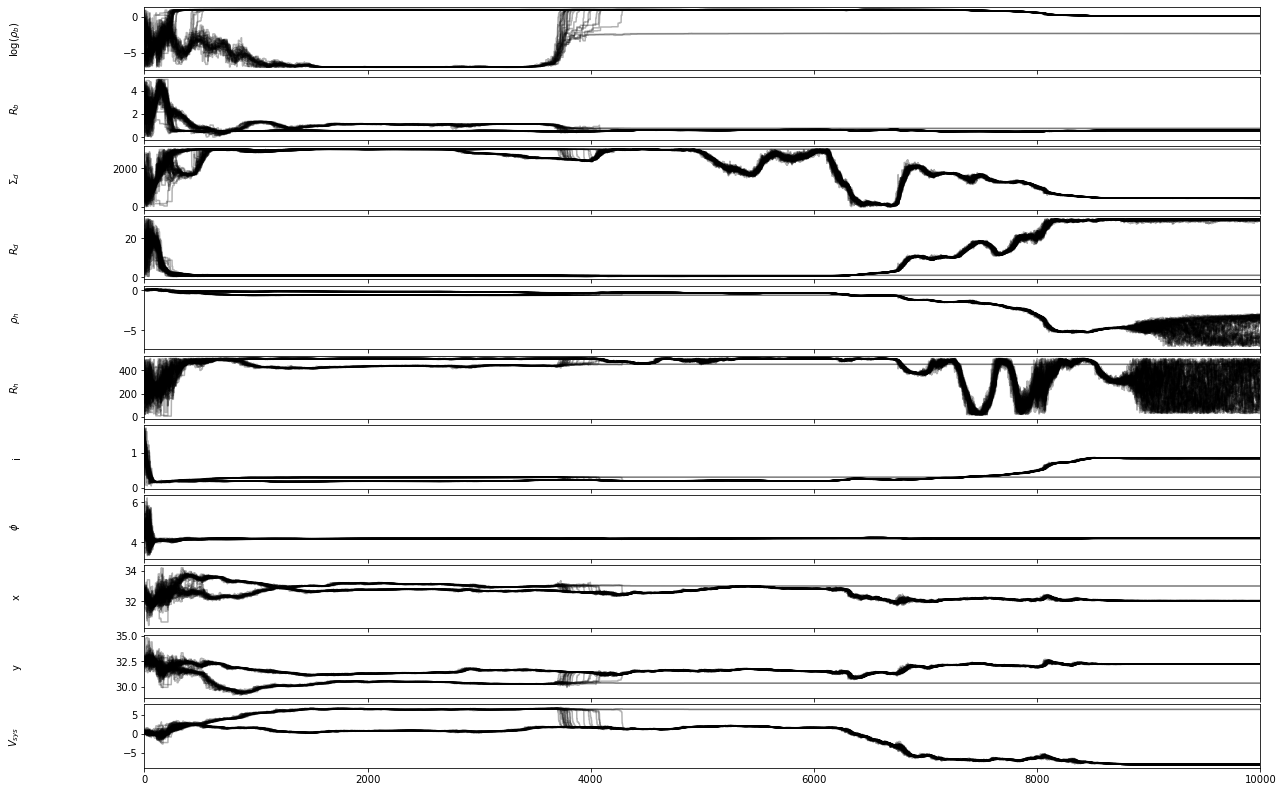

In [16]:
fig_iso, axes_iso = plt.subplots(11,1, 
                                 figsize=(20, 14), 
                                 sharex=True,
                                 gridspec_kw={'hspace':0.1}, 
                                 tight_layout=True)

for i in range(ndim_iso):
    ax = axes_iso[i]
    ax.plot(bad_samples_iso[:ns_iso,:,i], 'k', alpha=0.3)
    ax.set(xlim=(0,ns_iso), ylabel=labels[i])
    ax.yaxis.set_label_coords(-0.11, 0.5)

In [17]:
good_walkers_iso = np.load("../good_walkers_iso_7957-9102_comb.npy")

good_samples_iso = bad_samples_iso[:,good_walkers_iso,:]

In [18]:
flat_good_samples_iso = good_samples_iso.reshape(ns_iso*nw_iso, nd_iso)

trimmed_flat_good_samples_iso = good_samples_iso[3000:,:,:].reshape(7000*nw_iso, nd_iso)

/Users/richardzhang/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


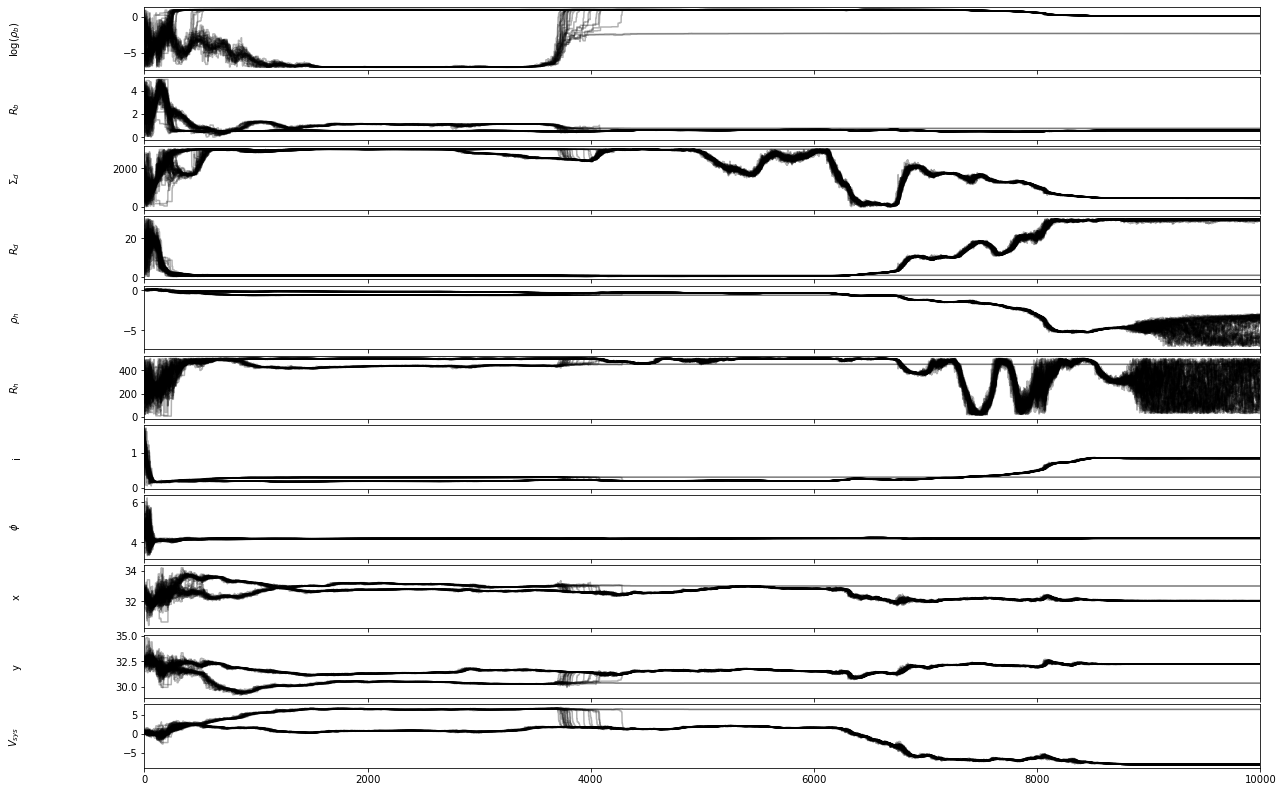

In [19]:
fig_iso, axes_iso = plt.subplots(11,1, 
                                 figsize=(20, 14), 
                                 sharex=True,
                                 gridspec_kw={'hspace':0.1}, 
                                 tight_layout=True)

for i in range(ndim_iso):
    ax = axes_iso[i]
    ax.plot(good_samples_iso[:ns_iso,:,i], 'k', alpha=0.3)
    ax.set(xlim=(0,ns_iso), ylabel=labels[i])
    ax.yaxis.set_label_coords(-0.11, 0.5)

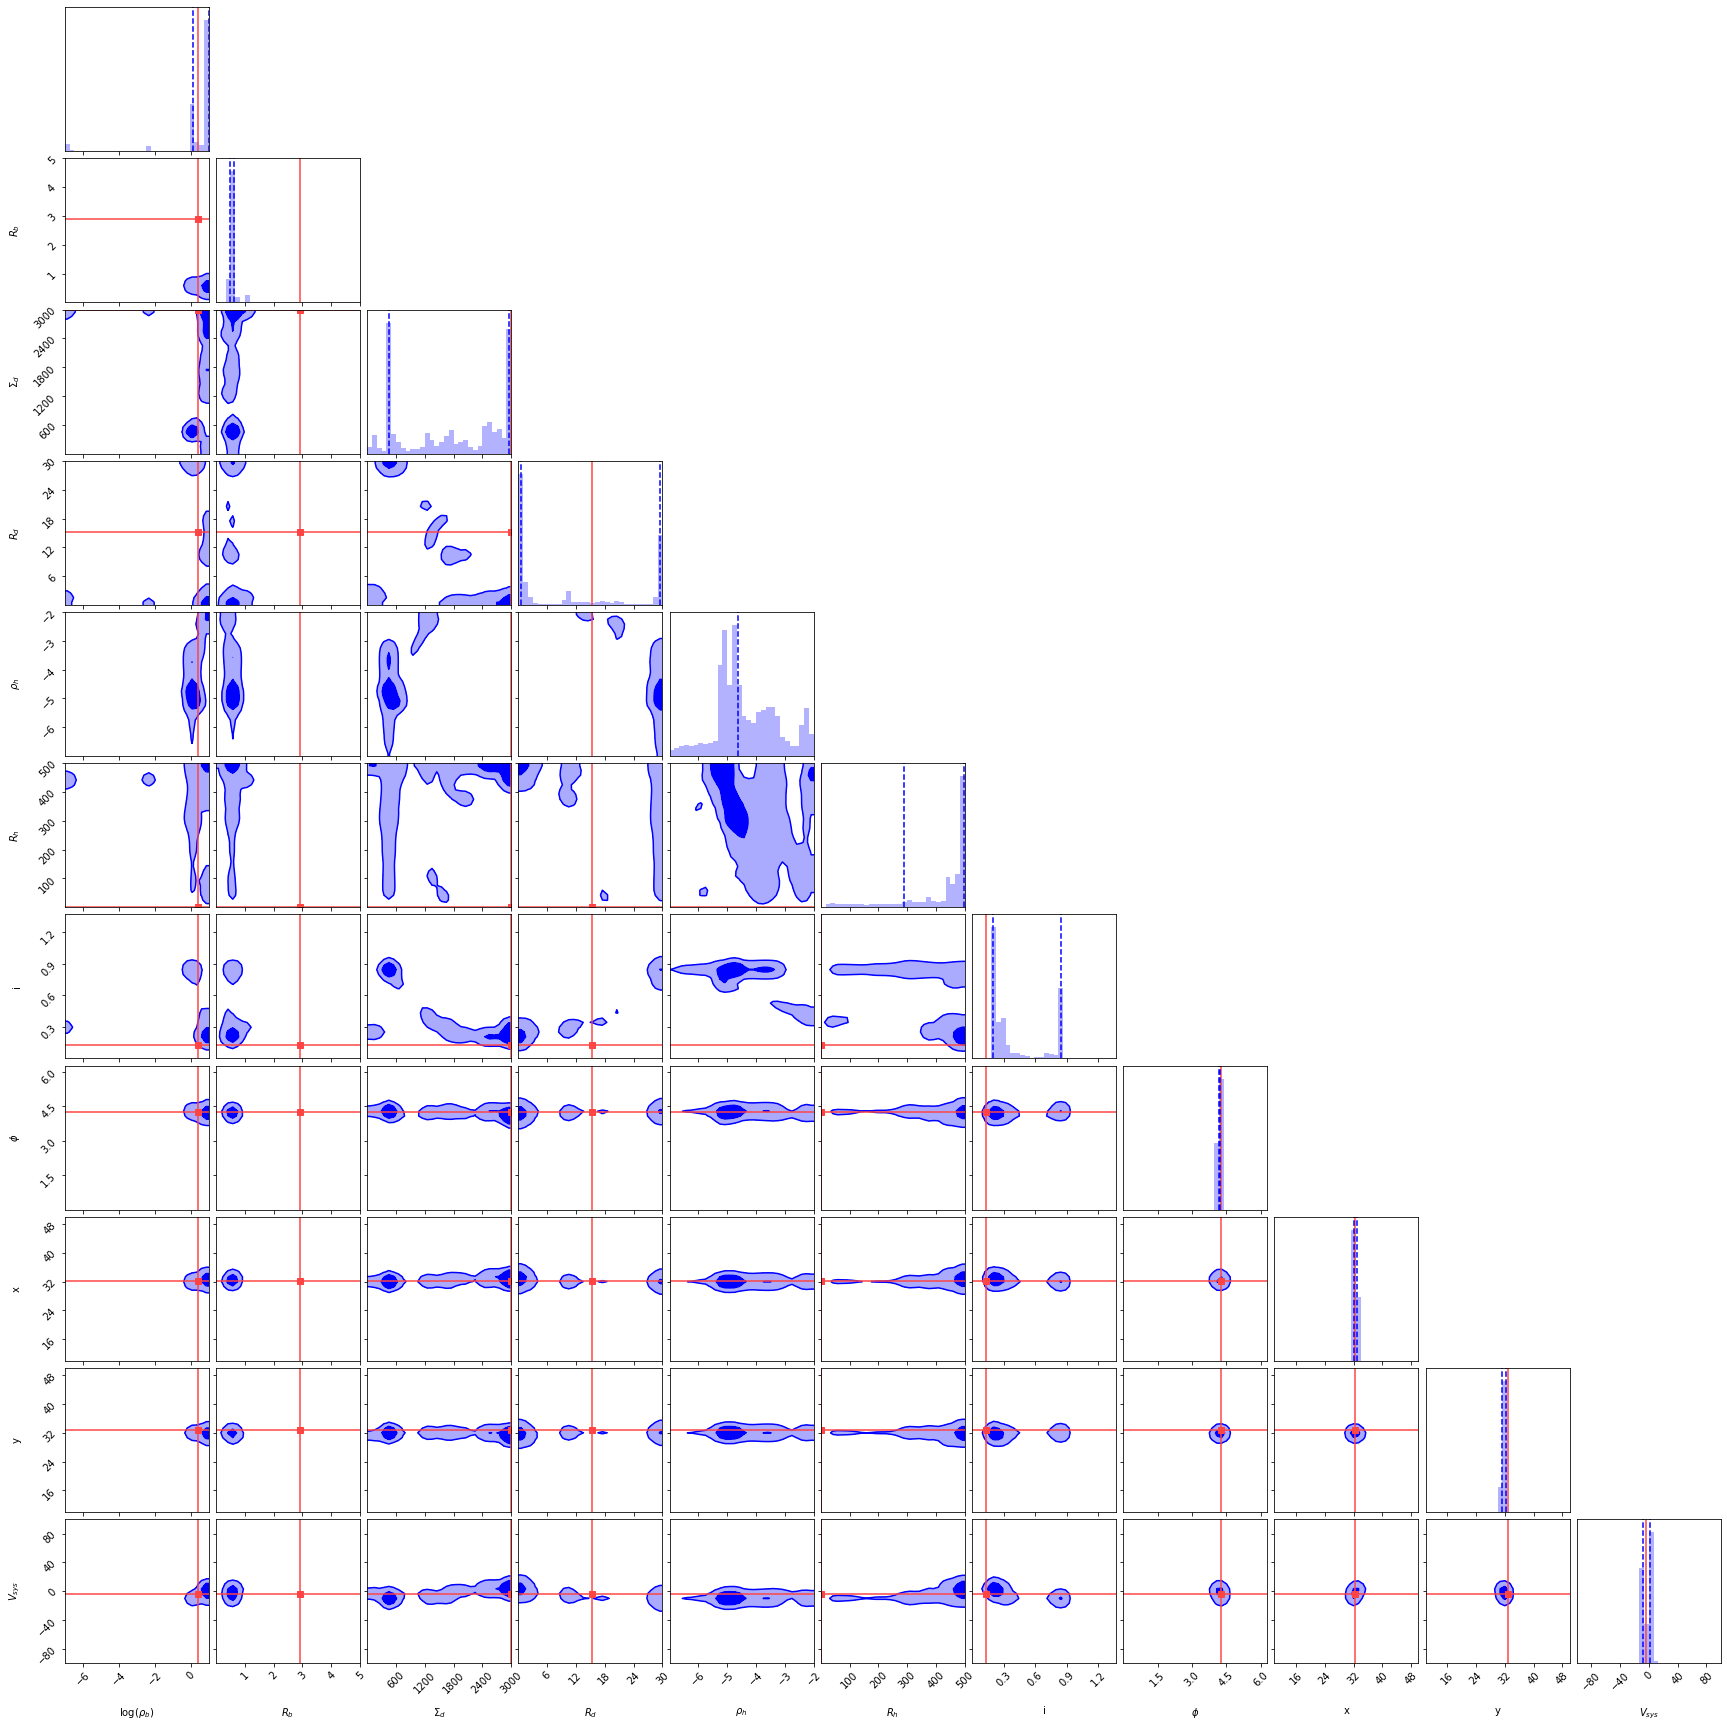

In [20]:
figure = corner.corner(trimmed_flat_good_samples_iso, labels=labels,
                       range=[(-7,1), (0,5), #(-8,0), (0,6), # Bulge density, radius
                              (0.1,3000), (0.1,30), # Disk density, radius
                              (-7,-2), (0.01,500), #(-8,2), (0,20), # Halo density, radius
                              (0,0.436*np.pi), # Inclination angle
                              (0,2*np.pi), # Rotation angle
                              (10,50), (10,50), # Center x, y
                              (-100,100)], # systemic velocity
                       bins=30,smooth=1,
                       truths=mini_soln_iso, 
                       truth_color='#ff4444',
                       levels=(1-np.exp(-0.5), 1-np.exp(-2)), 
                       quantiles=(0.16, 0.84),
                       hist_kwargs={'histtype':'stepfilled', 'alpha':0.3, 'density':True},
                       color='blue', plot_datapoints=False,
                       fill_contours=True)
#plt.savefig('corner_iso.png',format='png')

In [21]:
samples_mean_iso = np.mean(trimmed_flat_good_samples_iso, axis=0)
samples_mean_iso

array([ 2.88790429e-01,  5.98555704e-01,  1.71124268e+03,  1.09172271e+01,
       -1.78198616e+00,  4.08733045e+02,  4.05803999e-01,  4.19590152e+00,
        3.24209507e+01,  3.17006510e+01, -2.19527067e+00])

In [22]:
fitted_map_mcmc_iso = rot_incl_iso(gshape, scale, np.ndarray.tolist(samples_mean_iso))

mfitted_map_mcmc_iso = ma.array(fitted_map_mcmc_iso, mask=data_maps['Ha_vel_mask'])

residual_mcmc_iso = data_map - fitted_map_mcmc_iso

dist_mcmc_iso = residual_mcmc_iso*np.sqrt(ivar_masked)

mean of pull distribution mcmc: -1.7200369195024836
root mean square of pull distribution mcmc: 11.394601744218255
mean of pull distribution minimize: -2.244023223791401
root mean square of pull distribution minimize: 15.76924931093621


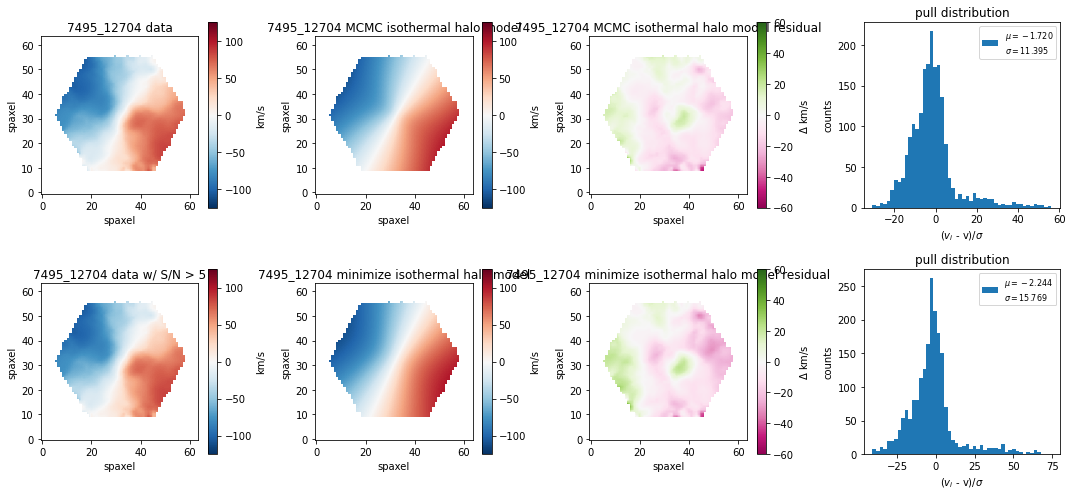

In [23]:
plt.figure(figsize=(15,7), tight_layout=True)


################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(241)

data_iso = plt.imshow(data_map, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-125, 
                      vmax=125)

plt.xlabel('spaxel')
plt.ylabel('spaxel')

cbar = plt.colorbar(data_iso)
cbar.set_label('km/s')

plt.title('7495_12704 data')
################################################################################


################################################################################
# Masked data
#-------------------------------------------------------------------------------
plt.subplot(245)

plt.imshow(vmasked, 
           origin='lower', 
           cmap='RdBu_r', 
           vmin=-125, 
           vmax=125)

plt.xlabel('spaxel')
plt.ylabel('spaxel')

cbar = plt.colorbar()
cbar.set_label('km/s')

plt.title('7495_12704 data w/ S/N > 5')
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(242)

iso_map_mcmc = plt.imshow(mfitted_map_mcmc_iso, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-125, 
                              vmax=125)

plt.xlabel('spaxel')
plt.ylabel('spaxel')

cbar = plt.colorbar(iso_map_mcmc)
cbar.set_label('km/s')

plt.title('7495_12704 MCMC isothermal halo model')
################################################################################


################################################################################
# MCMC residual
#-------------------------------------------------------------------------------
plt.subplot(243)

residual_mc_iso = plt.imshow(residual_mcmc_iso, 
                         origin='lower', 
                         cmap='PiYG', 
                         vmin=-60, 
                         vmax=60)

plt.xlabel('spaxel')
plt.ylabel('spaxel')

cbar = plt.colorbar(residual_mc_iso)
cbar.set_label('$\Delta$ km/s')

plt.title('7495_12704 MCMC isothermal halo model residual')
################################################################################


################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(246)

iso_map_minimize = plt.imshow(mfitted_map_minimize_iso, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-125, 
                              vmax=125)

plt.xlabel('spaxel')
plt.ylabel('spaxel')

cbar = plt.colorbar(iso_map_minimize)
cbar.set_label('km/s')

plt.title('7495_12704 minimize isothermal halo model')
################################################################################


################################################################################
# minimize residual
#-------------------------------------------------------------------------------
plt.subplot(247)

residual_mini_iso = plt.imshow(residual_minimize_iso, 
                           origin='lower', 
                           cmap='PiYG', 
                           vmin=-60, 
                           vmax=60)

plt.xlabel('spaxel')
plt.ylabel('spaxel')

cbar = plt.colorbar(residual_mini_iso)
cbar.set_label('$\Delta$ km/s')

plt.title('7495_12704 minimize isothermal halo model residual');
################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(244)

mean_mcmc_iso = ma.mean(dist_mcmc_iso)
sig_mcmc_iso = ma.std(dist_mcmc_iso)

dist_mcmc_iso = residual_mcmc_iso*np.sqrt(data_maps['ivar_masked'])

n_mcmc_iso, bins_mcmc_iso, patches_mcmc_iso = plt.hist(dist_mcmc_iso.compressed(),bins=50,
                                                      label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_iso, sig_mcmc_iso))

plt.xlabel('($v_i$ - v)/$\sigma$')
plt.ylabel('counts')
plt.title('pull distribution')
plt.legend(loc='upper right', fontsize=8)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(248)

mean_mini_iso = ma.mean(dist_minimize_iso)
sig_mini_iso = ma.std(dist_minimize_iso)

dist_minimize_iso = residual_minimize_iso*np.sqrt(data_maps['ivar_masked'])

n_mini_iso, bins_mini_iso, patches_mini_iso = plt.hist(dist_minimize_iso.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_iso, sig_mini_iso))

plt.xlabel('($v_i$ - v)/$\sigma$')
plt.ylabel('counts')
plt.title('pull distribution')
plt.legend(loc='upper right', fontsize=8)

################################################################################

print('mean of pull distribution mcmc: ' + str(mean_mcmc_iso))
print('root mean square of pull distribution mcmc: ' + str(sig_mcmc_iso))
print('mean of pull distribution minimize: ' + str(mean_mini_iso))
print('root mean square of pull distribution minimize: ' + str(sig_mini_iso))

In [24]:
nd_iso_mcmc = np.sum(~mfitted_map_mcmc_iso.mask)

# chi2_iso = np.nansum((vmasked - vmap_iso) ** 2 * Ha_vel_ivar)
chi2_iso_mcmc = ma.sum(data_maps['Ha_vel_ivar'] * (data_map - mfitted_map_mcmc_iso) ** 2)

# chi2_iso_norm = chi2_iso/(nd_iso - 8)
chi2_iso_norm_mcmc = chi2_iso_mcmc / (nd_iso_mcmc - len(samples_mean_iso))
chi2_iso_norm_mcmc

133.3996799842849

In [25]:
nd_iso_minimize = np.sum(~mfitted_map_minimize_iso.mask)

# chi2_iso = np.nansum((vmasked - vmap_iso) ** 2 * Ha_vel_ivar)
chi2_iso_minimize = ma.sum(data_maps['Ha_vel_ivar'] * (data_map - mfitted_map_minimize_iso) ** 2)

# chi2_iso_norm = chi2_iso/(nd_iso - 8)
chi2_iso_norm_minimize = chi2_iso_minimize / (nd_iso_minimize - len(mini_soln_iso))
chi2_iso_norm_minimize

254.8581563666921

# NFW

In [26]:
'''mini_soln_NFW = [np.log10(5.315237789),
                 0.1472824,
                 417.348003,
                 11.71427151,
                 0.003456733,
                 20.53074275,
                 0.865871265,
                 1.969515296,
                 25.83823628,
                 27.65695241,
                 4.516715936]
'''
mini_soln_NFW = [0.84204231,
                 0.495058027,
                 1567.972898,
                 4.404238045,
                 -5.912279055,
                 999.4841331,
                 0.330454128,
                 4.185646237,
                 32.06074902,
                 32.2152774,
                 -7.574170594]

# NFW w/ Combination

In [28]:
bad_samples_NFW = np.load("../bad_samples_NFW_7957-9102_comb.npy")
#bad_samples_NFW

In [29]:
ns_NFW, nw_NFW, nd_NFW = bad_samples_NFW.shape
#ns_NFW, nw_NFW, nd_NFW

In [30]:
flat_bad_samples_NFW = bad_samples_NFW.reshape(ns_NFW*nw_NFW, nd_NFW)
#flat_bad_samples_NFW

In [31]:
pos_model_7495_12704 = np.random.uniform(low=[-7,0.00001,200,0.1,2e-5,0.1], 
                        high=[1,5,2500,25,0.1,500], 
                        size=(64,6))

pos_geo_7495_12704 = np.array(geo_guesses_7495_12704) + np.random.uniform(np.random.uniform(low=-1e-3*np.ones(len(geo_guesses_7495_12704)), 
                                              high=1e-3*np.ones(len(geo_guesses_7495_12704)), 
                                              size=(64,len(geo_guesses_7495_12704))))

pos_NFW = np.column_stack((pos_model_7495_12704,pos_geo_7495_12704))

In [32]:
nwalkers_NFW, ndim_NFW = pos_NFW.shape
nwalkers_NFW, ndim_NFW

(64, 11)

/Users/richardzhang/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


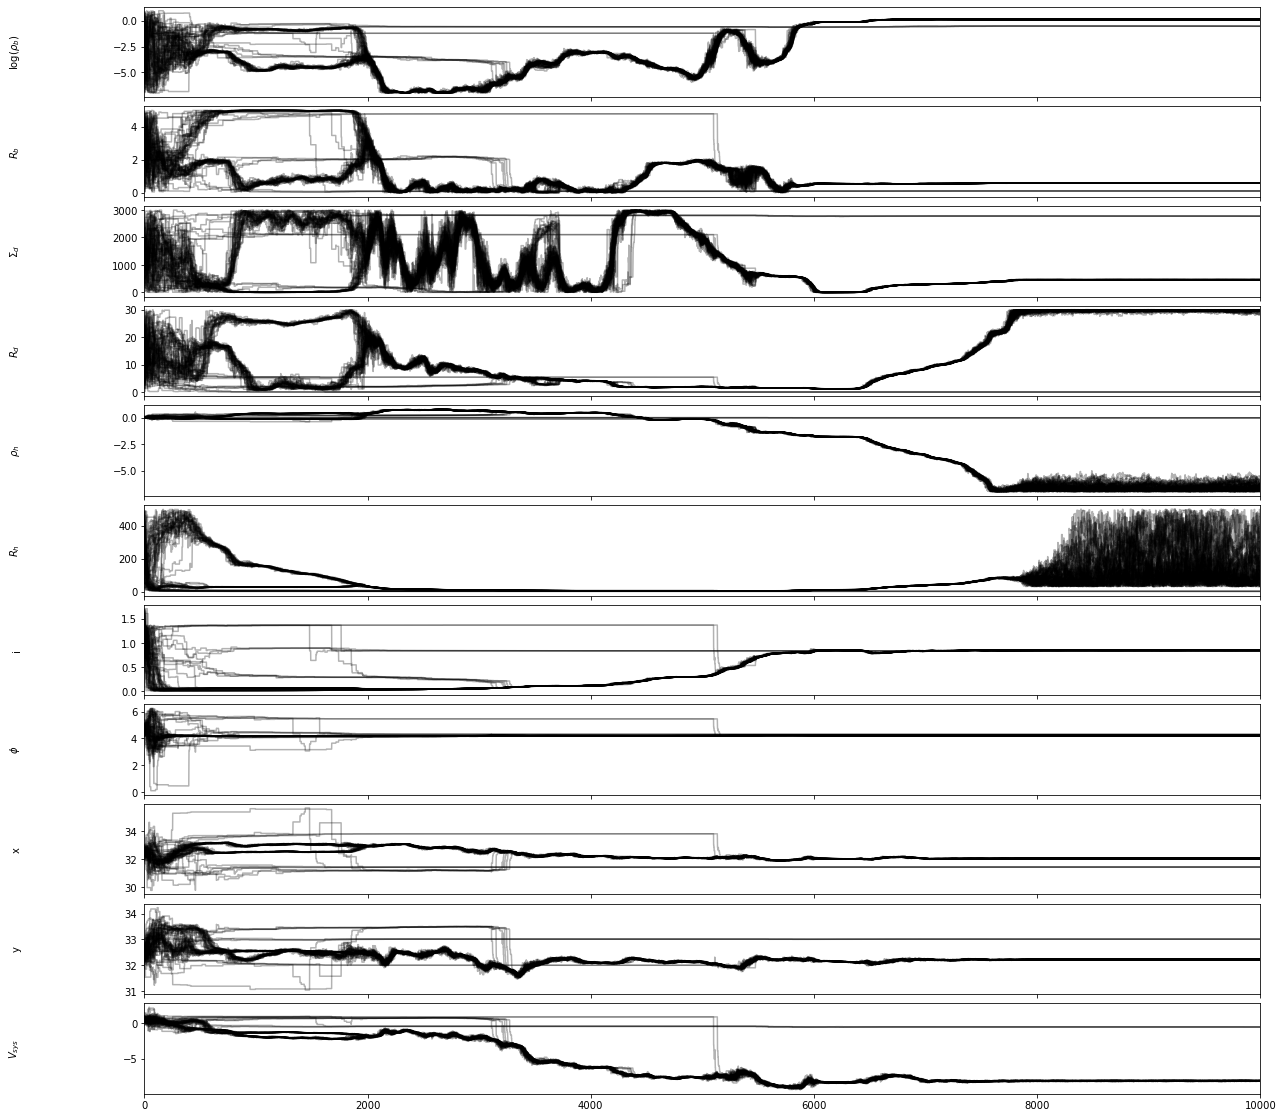

In [33]:
fig_NFW, axes_NFW = plt.subplots(11,1, 
                                 figsize=(20, 20), 
                                 sharex=True,
                                 gridspec_kw={'hspace':0.1}, 
                                 tight_layout=True)

for i in range(ndim_NFW):
    ax = axes_NFW[i]
    ax.plot(bad_samples_NFW[:ns_NFW,:,i], 'k', alpha=0.3)
    ax.set(xlim=(0,ns_NFW),ylabel=labels[i])
    ax.yaxis.set_label_coords(-0.11, 0.5)

In [34]:
good_walkers_NFW = np.load("../good_walkers_iso_7957-9102_comb.npy")

good_samples_NFW = bad_samples_NFW[:,good_walkers_iso,:]

In [35]:
flat_good_samples_NFW = good_samples_NFW.reshape(ns_NFW*nw_NFW, nd_NFW)

trimmed_flat_good_samples_NFW = good_samples_NFW[4000:,:,:].reshape(6000*nw_NFW, nd_NFW)

/Users/richardzhang/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


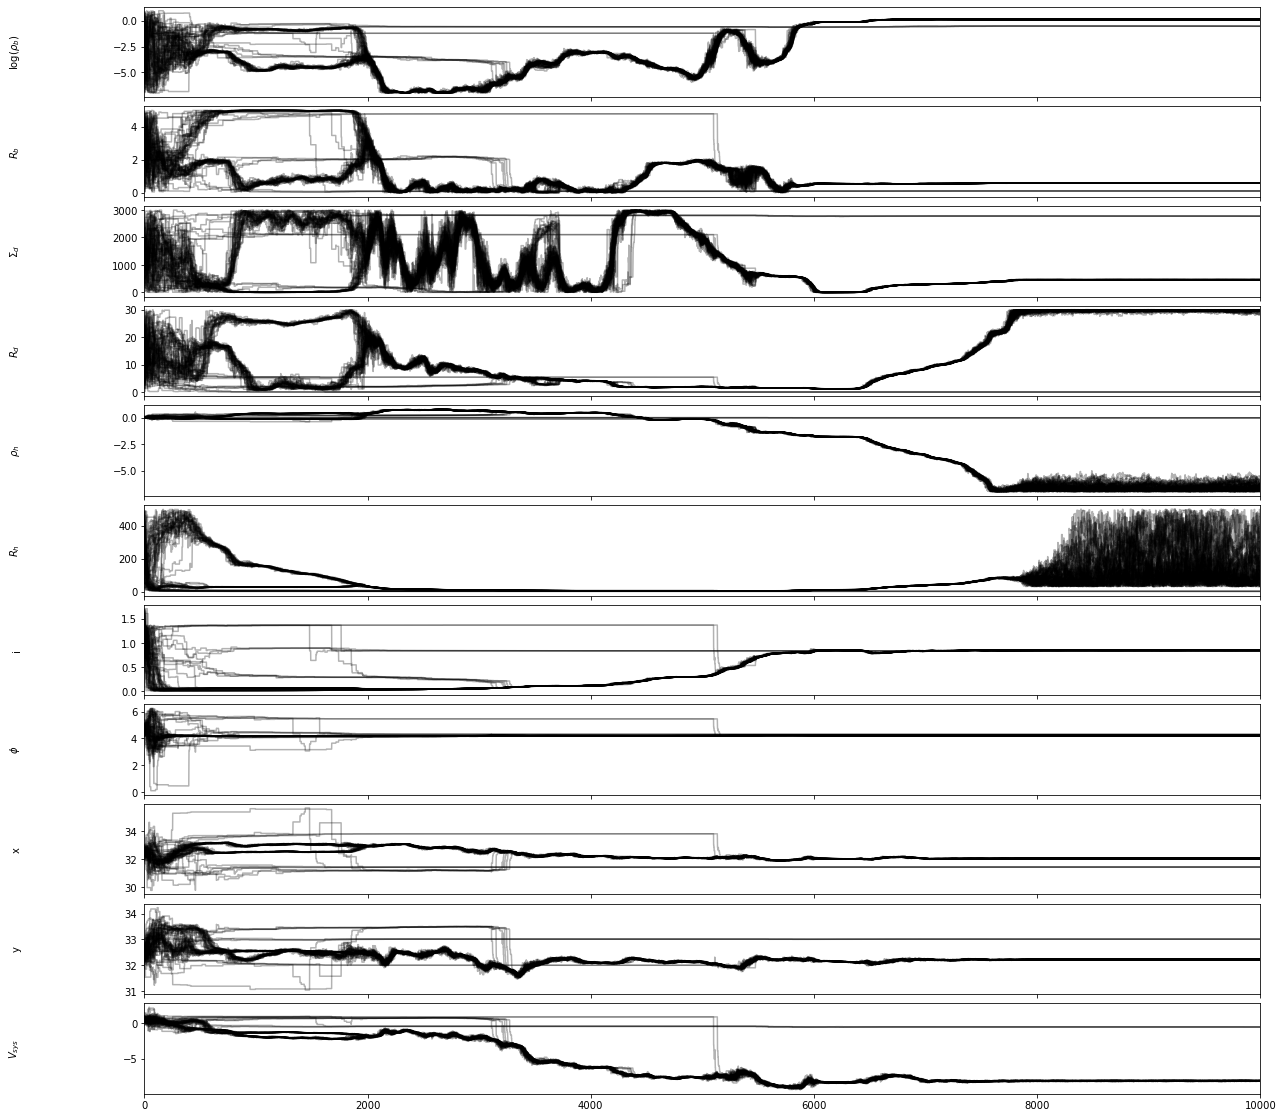

In [36]:
fig_NFW, axes_NFW = plt.subplots(11,1, 
                                 figsize=(20, 20), 
                                 sharex=True,
                                 gridspec_kw={'hspace':0.1}, 
                                 tight_layout=True)

for i in range(ndim_NFW):
    ax = axes_NFW[i]
    ax.plot(good_samples_NFW[:ns_NFW,:,i], 'k', alpha=0.3)
    ax.set(xlim=(0,ns_NFW),ylabel=labels[i])
    ax.yaxis.set_label_coords(-0.11, 0.5)

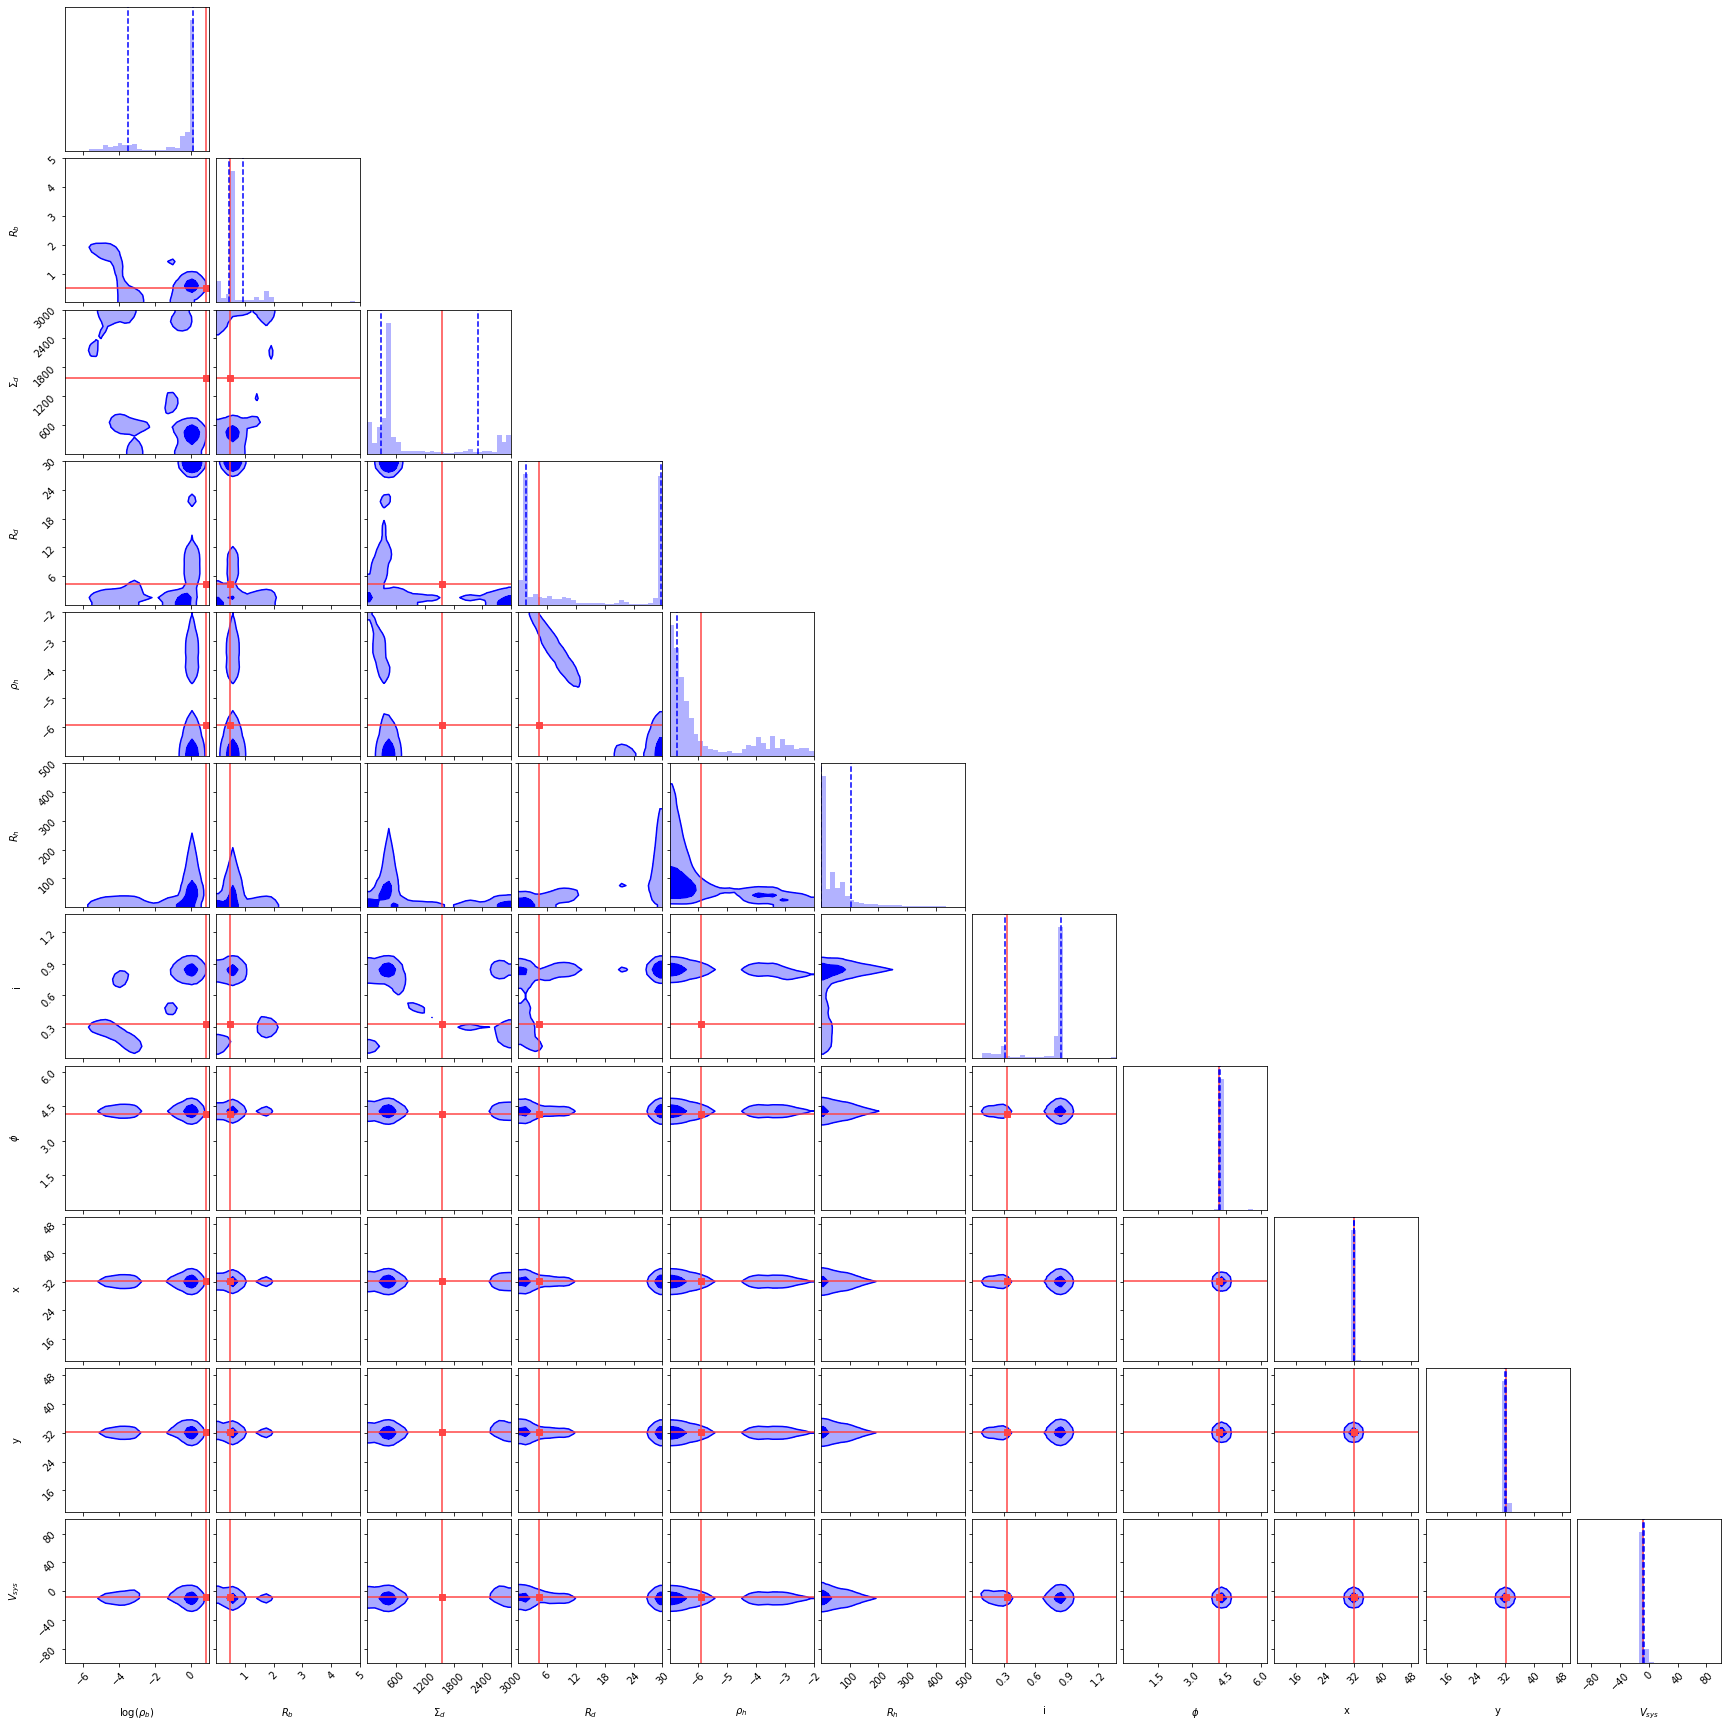

In [37]:
figure = corner.corner(trimmed_flat_good_samples_NFW, labels=labels,
                       range=[(-7,1), (0,5), #(-8,0), (0,6), # Bulge density, radius
                              (0.1,3000), (0.1,30), # Disk density, radius
                              (-7,-2), (0.01,500), #(-8,2), (0,20), # Halo density, radius
                              (0,0.436*np.pi), # Inclination angle
                              (0,2*np.pi), # Rotation angle
                              (10,50), (10,50), # Center x, y
                              (-100,100)], # systemic velocity
                       bins=30,smooth=1,
                       truths=mini_soln_NFW, 
                       truth_color='#ff4444',
                       levels=(1-np.exp(-0.5), 1-np.exp(-2)), 
                       quantiles=(0.16, 0.84),
                       hist_kwargs={'histtype':'stepfilled', 'alpha':0.3, 'density':True},
                       color='blue', plot_datapoints=False,
                       fill_contours=True)
#plt.savefig('corner_iso.png',format='png')

In [38]:
samples_mean_NFW = np.mean(trimmed_flat_good_samples_NFW, axis=0)
samples_mean_NFW

array([-9.79911949e-01,  6.94365131e-01,  8.67566098e+02,  1.34054057e+01,
       -3.44040188e+00,  5.99721187e+01,  7.16764152e-01,  4.22135779e+00,
        3.20185194e+01,  3.22361062e+01, -7.44799382e+00])

In [39]:
fitted_map_mcmc_NFW = rot_incl_NFW(gshape, scale, np.ndarray.tolist(samples_mean_NFW))

mfitted_map_mcmc_NFW = ma.array(fitted_map_mcmc_NFW, mask=data_maps['Ha_vel_mask'])

residual_mcmc_NFW = data_map - fitted_map_mcmc_NFW

dist_mcmc_NFW = residual_mcmc_NFW*np.sqrt(ivar_masked)

In [40]:
fitted_map_minimize_NFW = rot_incl_NFW(gshape, scale, mini_soln_NFW)

mfitted_map_minimize_NFW = ma.array(fitted_map_minimize_NFW, mask=data_maps['Ha_vel_mask'])

residual_minimize_NFW = data_map - fitted_map_minimize_NFW

dist_minimize_NFW = residual_minimize_NFW*np.sqrt(ivar_masked)

mean of pull distribution mcmc NFW: 1.2423322558265684
root mean square of pull distribution mcmc NFW: 16.785034782462134
mean of pull distribution minimize NFW: -0.46424186599935297
root mean square of pull distribution minimize NFW: 16.785034782462134


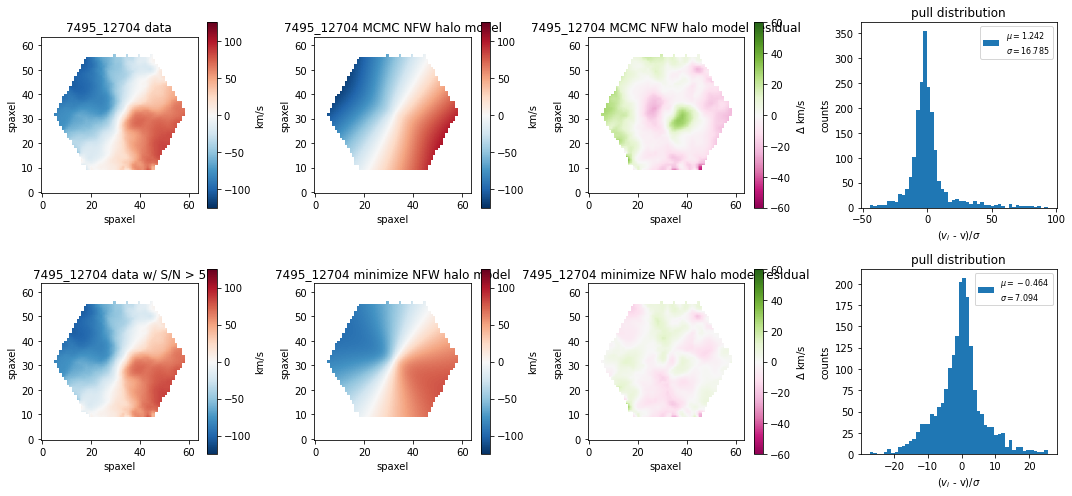

In [41]:
plt.figure(figsize=(15,7), tight_layout=True)


################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(241)

data_NFW = plt.imshow(data_map, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-125, 
                      vmax=125)

plt.xlabel('spaxel')
plt.ylabel('spaxel')

cbar = plt.colorbar(data_iso)
cbar.set_label('km/s')

plt.title('7495_12704 data')
################################################################################


################################################################################
# Masked data
#-------------------------------------------------------------------------------
plt.subplot(245)

plt.imshow(vmasked, 
           origin='lower', 
           cmap='RdBu_r', 
           vmin=-125, 
           vmax=125)

plt.xlabel('spaxel')
plt.ylabel('spaxel')

cbar = plt.colorbar()
cbar.set_label('km/s')

plt.title('7495_12704 data w/ S/N > 5')
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(242)

NFW_map_minimize = plt.imshow(mfitted_map_mcmc_NFW, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-125, 
                              vmax=125)

plt.xlabel('spaxel')
plt.ylabel('spaxel')

cbar = plt.colorbar(NFW_map_minimize)
cbar.set_label('km/s')

plt.title('7495_12704 MCMC NFW halo model')
################################################################################


################################################################################
# MCMC residual
#-------------------------------------------------------------------------------
plt.subplot(243)

residual_mc_NFW = plt.imshow(residual_mcmc_NFW, 
                             origin='lower', 
                             cmap='PiYG', 
                             vmin=-60, 
                             vmax=60)

plt.xlabel('spaxel')
plt.ylabel('spaxel')

cbar = plt.colorbar(residual_mc_NFW)
cbar.set_label('$\Delta$ km/s')

plt.title('7495_12704 MCMC NFW halo model residual')
################################################################################


################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(246)

NFW_map_minimize = plt.imshow(mfitted_map_minimize_NFW, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-125, 
                              vmax=125)

plt.xlabel('spaxel')
plt.ylabel('spaxel')

cbar = plt.colorbar(NFW_map_minimize)
cbar.set_label('km/s')

plt.title('7495_12704 minimize NFW halo model')
################################################################################


################################################################################
# minimize residual
#-------------------------------------------------------------------------------
plt.subplot(247)

residual_mini_NFW = plt.imshow(residual_minimize_NFW, 
                               origin='lower', 
                               cmap='PiYG', 
                               vmin=-60, 
                               vmax=60)

plt.xlabel('spaxel')
plt.ylabel('spaxel')

cbar = plt.colorbar(residual_mini_NFW)
cbar.set_label('$\Delta$ km/s')

plt.title('7495_12704 minimize NFW halo model residual');
################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(244)

mean_mcmc_NFW = ma.mean(dist_mcmc_NFW)
sig_mcmc_NFW = ma.std(dist_mcmc_NFW)

dist_mcmc_NFW = residual_mcmc_NFW*np.sqrt(data_maps['ivar_masked'])

n_mcmc_NFW, bins_mcmc_NFW, patches_mcmc_NFW = plt.hist(dist_mcmc_NFW.compressed(),bins=50,
                                                      label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_NFW, sig_mcmc_NFW))

plt.xlabel('($v_i$ - v)/$\sigma$')
plt.ylabel('counts')
plt.title('pull distribution')
plt.legend(loc='upper right', fontsize=8)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(248)

mean_mini_NFW = ma.mean(dist_minimize_NFW)
sig_mini_NFW = ma.std(dist_minimize_NFW)

dist_minimize_NFW = residual_minimize_NFW*np.sqrt(data_maps['ivar_masked'])

n_mini_NFW, bins_mini_NFW, patches_mini_NFW = plt.hist(dist_minimize_NFW.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_NFW, sig_mini_NFW))

plt.xlabel('($v_i$ - v)/$\sigma$')
plt.ylabel('counts')
plt.title('pull distribution')
plt.legend(loc='upper right', fontsize=8)

################################################################################

print('mean of pull distribution mcmc NFW: ' + str(mean_mcmc_NFW))
print('root mean square of pull distribution mcmc NFW: ' + str(sig_mcmc_NFW))
print('mean of pull distribution minimize NFW: ' + str(mean_mini_NFW))
print('root mean square of pull distribution minimize NFW: ' + str(sig_mcmc_NFW))

In [42]:
nd_NFW_mcmc = np.sum(~mfitted_map_mcmc_NFW.mask)

chi2_NFW_mcmc = ma.sum(data_maps['Ha_vel_ivar'] * (data_map - mfitted_map_mcmc_NFW)**2)

chi2_NFW_norm_mcmc = chi2_NFW_mcmc / (nd_NFW_mcmc - len(samples_mean_NFW))
chi2_NFW_norm_mcmc

284.56856282538996

In [43]:
nd_NFW_minimize = np.sum(~mfitted_map_minimize_NFW.mask)

chi2_NFW_minimize = ma.sum(data_maps['Ha_vel_ivar'] * (data_map - mfitted_map_minimize_NFW)**2)

chi2_NFW_norm_minimize = chi2_NFW_minimize / (nd_NFW_minimize - len(mini_soln_NFW))
chi2_NFW_norm_minimize

50.77648957544055

# Burket

In [44]:
mini_soln_bur = [-6.999945833,
                 4.27030555,
                 2999.999855,
                 13.97648263,
                 -6.999949836,
                 982.7864899,
                 0.488138534,
                 2.977191462,
                 41.99995965,
                 30.80424999,
                 -22.0800593]

In [45]:
fitted_map_minimize_bur = rot_incl_NFW(gshape, scale, mini_soln_bur)

mfitted_map_minimize_bur = ma.array(fitted_map_minimize_bur, mask=data_maps['Ha_vel_mask'])

residual_minimize_bur = data_map - fitted_map_minimize_bur

dist_minimize_bur = residual_minimize_bur*np.sqrt(ivar_masked)

# Burket w/ Combination

In [46]:
bad_samples_bur = np.load("../bad_samples_bur_7957-9102_comb.npy")

In [47]:
ns_bur, nw_bur, nd_bur = bad_samples_bur.shape
ns_bur, nw_bur, nd_bur

(10000, 64, 11)

In [48]:
flat_bad_samples_bur = bad_samples_bur.reshape(ns_bur*nw_bur, nd_bur)

In [49]:
pos_model_7495_12704 = np.random.uniform(low=[-7,0.00001,200,0.1,2e-5,0.1], 
                        high=[1,5,2500,25,0.1,500], 
                        size=(64,6))

pos_geo_7495_12704 = np.array(geo_guesses_7495_12704) + np.random.uniform(np.random.uniform(low=-1e-3*np.ones(len(geo_guesses_7495_12704)), 
                                              high=1e-3*np.ones(len(geo_guesses_7495_12704)), 
                                              size=(64,len(geo_guesses_7495_12704))))

pos_bur = np.column_stack((pos_model_7495_12704,pos_geo_7495_12704))

In [50]:
nwalkers_bur, ndim_bur = pos_bur.shape

/Users/richardzhang/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


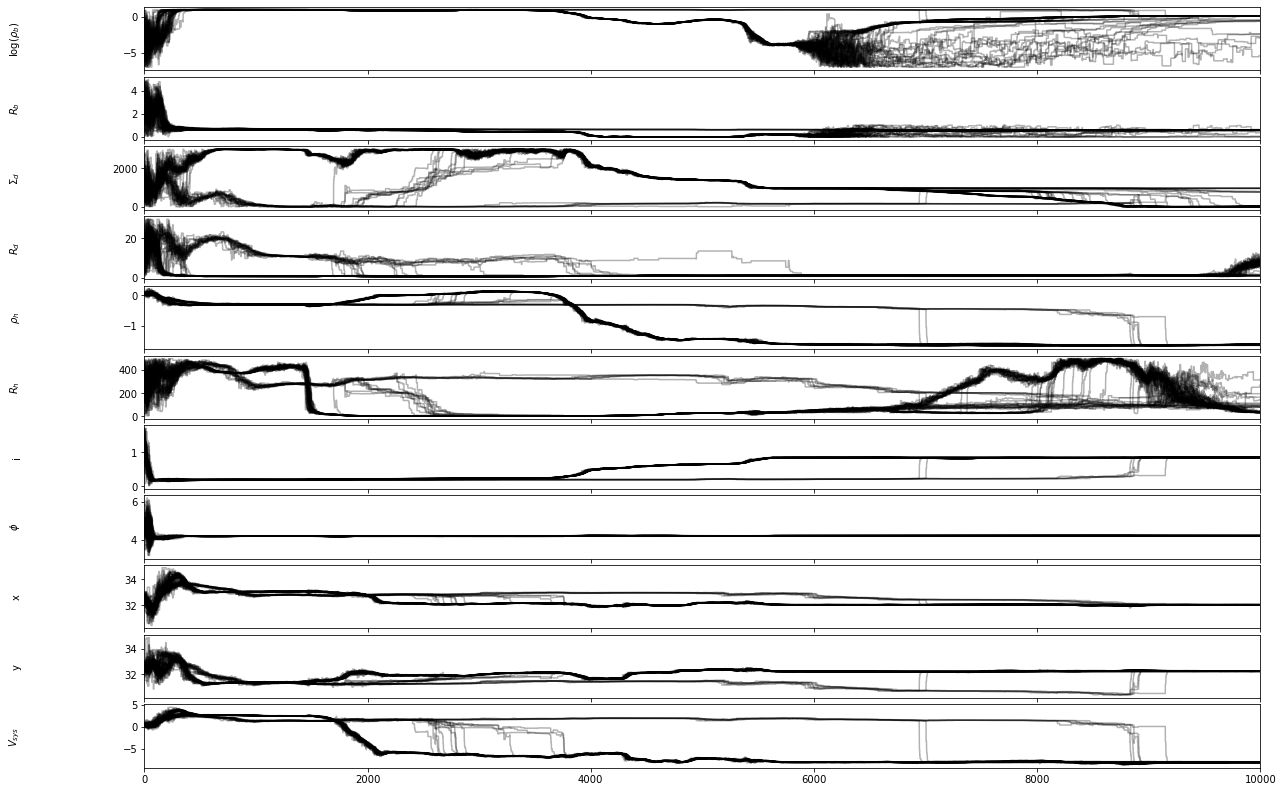

In [51]:
fig_bur, axes_bur = plt.subplots(11,1, 
                                 figsize=(20, 14), 
                                 sharex=True,
                                 gridspec_kw={'hspace':0.1}, 
                                 tight_layout=True)

for i in range(ndim_bur):
    ax = axes_bur[i]
    ax.plot(bad_samples_bur[:ns_bur,:,i], 'k', alpha=0.3)
    ax.set(xlim=(0,ns_bur), ylabel=labels[i])
    ax.yaxis.set_label_coords(-0.11, 0.5)

In [52]:
good_walkers_bur = np.load("../good_walkers_bur_7957-9102_comb.npy")

good_samples_bur = bad_samples_bur[:,good_walkers_bur,:]

In [53]:
flat_good_samples_bur = good_samples_bur.reshape(ns_bur*nw_bur, nd_bur)

trimmed_flat_good_samples_bur = good_samples_bur[4000:,:,:].reshape(6000*nw_bur, nd_bur)

/Users/richardzhang/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


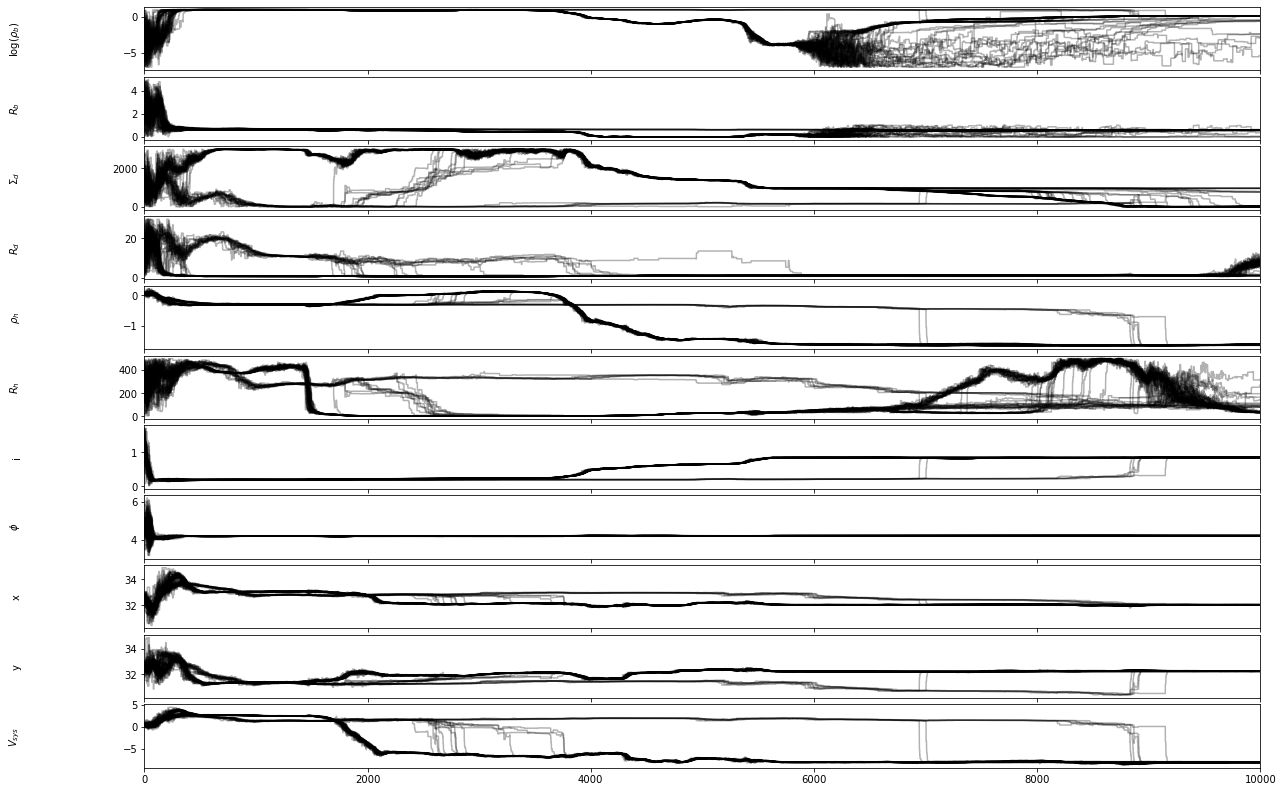

In [54]:
fig_bur, axes_bur = plt.subplots(11,1, 
                                 figsize=(20, 14), 
                                 sharex=True,
                                 gridspec_kw={'hspace':0.1}, 
                                 tight_layout=True)

for i in range(ndim_bur):
    ax = axes_bur[i]
    ax.plot(good_samples_bur[:ns_bur,:,i], 'k', alpha=0.3)
    ax.set(xlim=(0,ns_bur), ylabel=labels[i])
    ax.yaxis.set_label_coords(-0.11, 0.5)

/Users/richardzhang/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


ValueError: Axis limits cannot be NaN or Inf

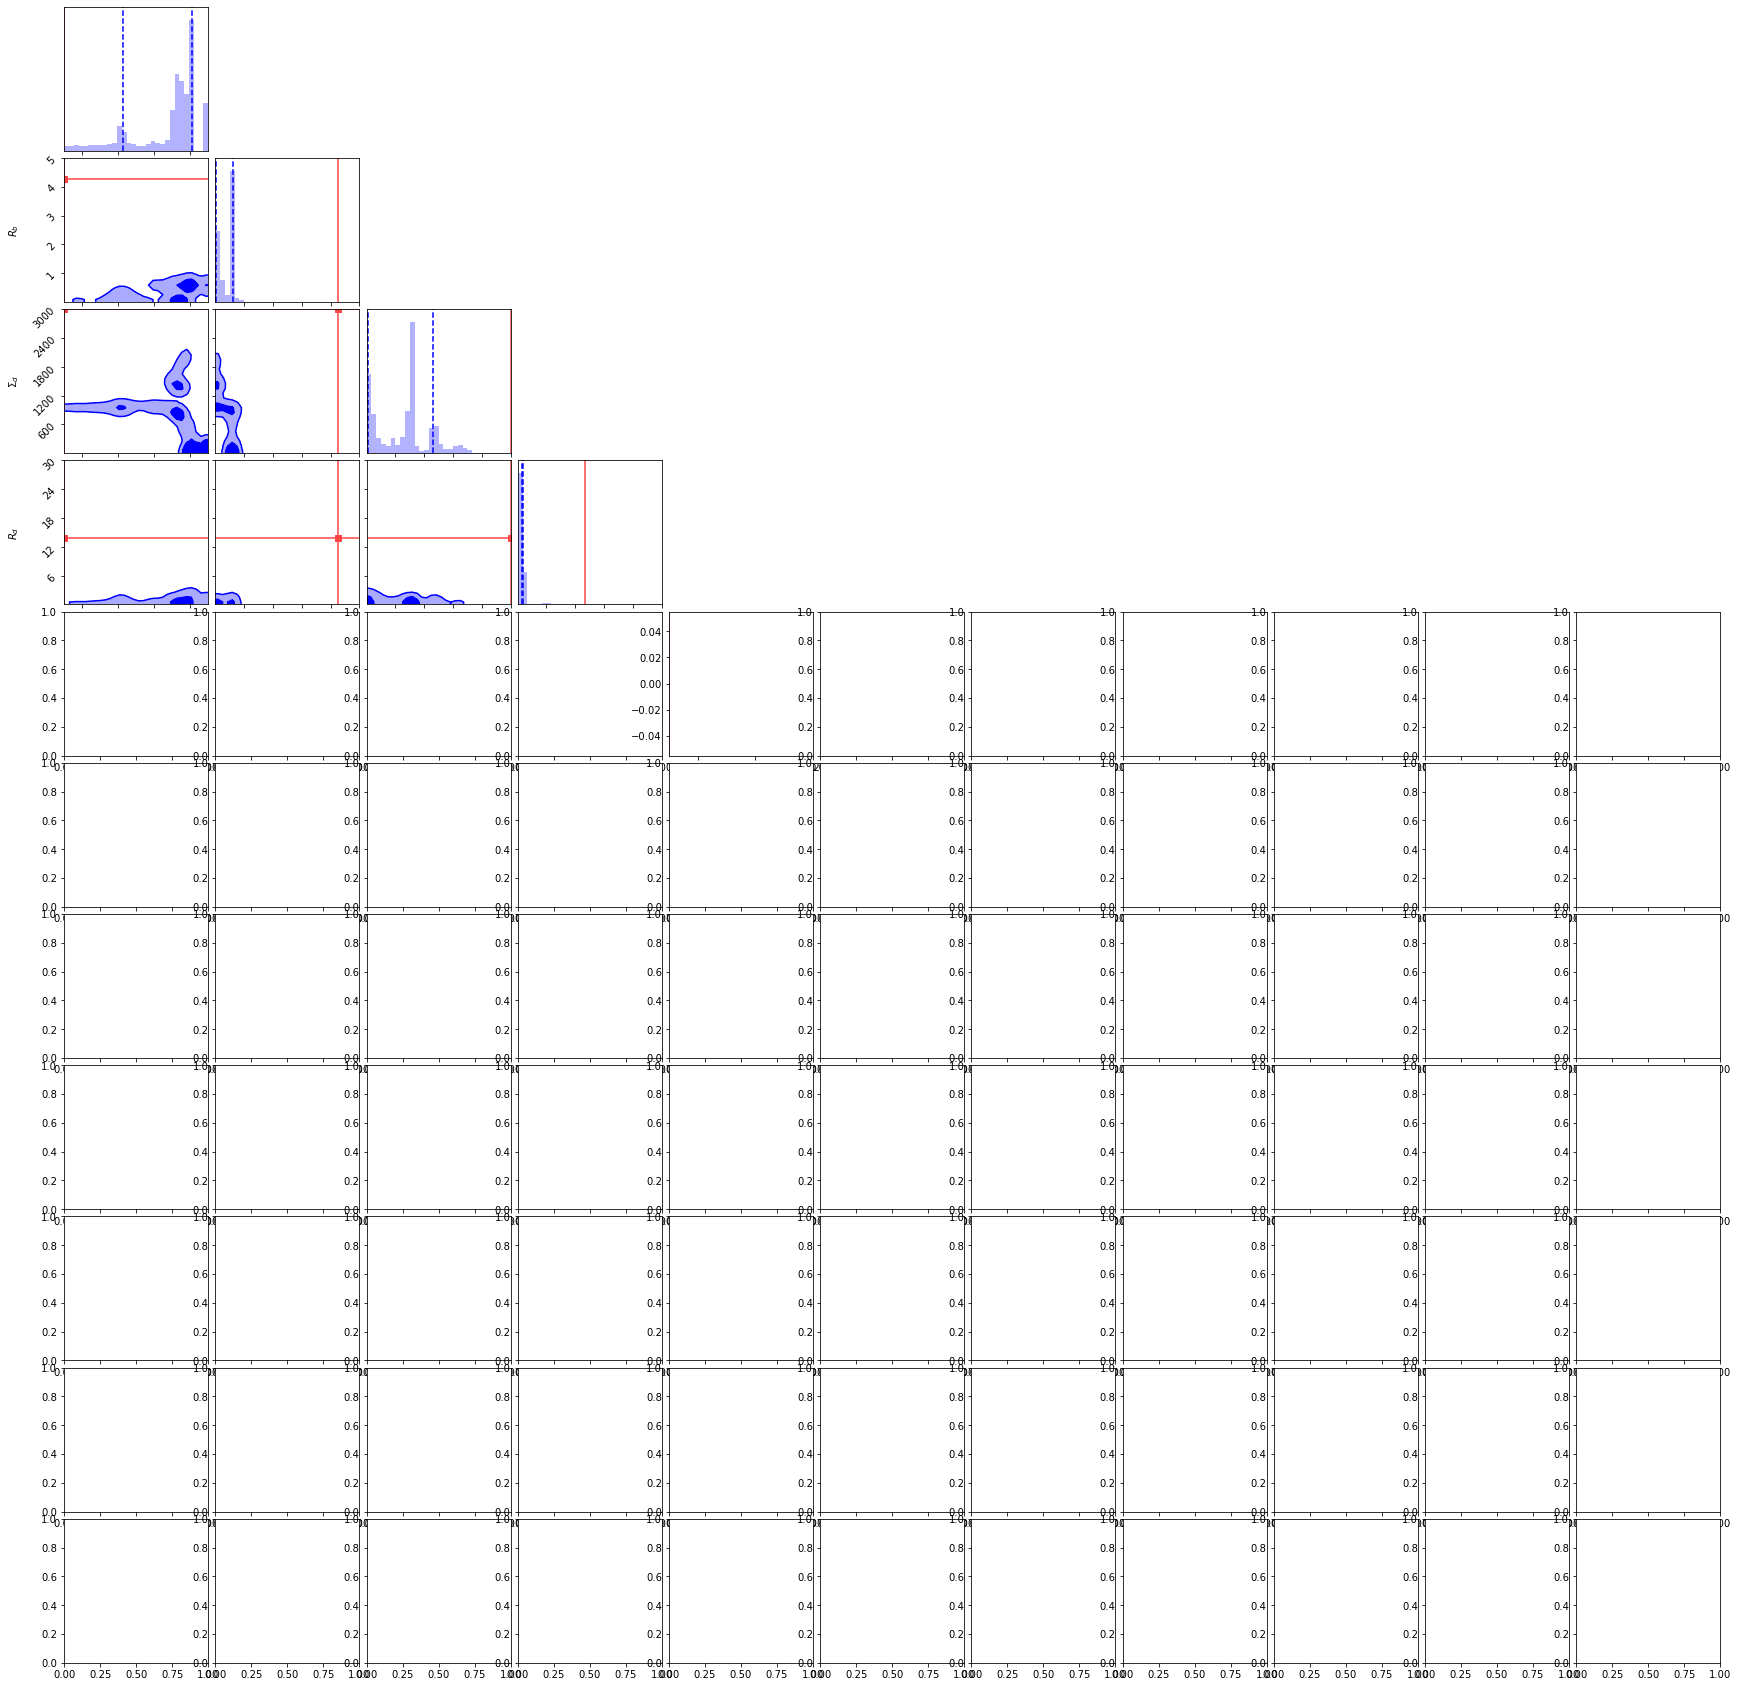

In [55]:
figure = corner.corner(trimmed_flat_good_samples_bur, labels=labels,
                       range=[(-7,1), (0,5), #(-8,0), (0,6), # Bulge density, radius
                              (0.1,3000), (0.1,30), # Disk density, radius
                              (-7,-2), (0.01,500), #(-8,2), (0,20), # Halo density, radius
                              (0,0.436*np.pi), # Inclination angle
                              (0,2*np.pi), # Rotation angle
                              (10,50), (10,50), # Center x, y
                              (-100,100)], # systemic velocity
                       bins=30,smooth=1,
                       truths=mini_soln_bur, 
                       truth_color='#ff4444',
                       levels=(1-np.exp(-0.5), 1-np.exp(-2)), 
                       quantiles=(0.16, 0.84),
                       hist_kwargs={'histtype':'stepfilled', 'alpha':0.3, 'density':True},
                       color='blue', plot_datapoints=False,
                       fill_contours=True)

In [56]:
samples_mean_bur = np.mean(trimmed_flat_good_samples_bur, axis=0)
samples_mean_bur

array([-1.22875589e+00,  3.94794241e-01,  7.83394757e+02,  1.23861793e+00,
       -1.46299820e+00,  1.34536482e+02,  7.44797242e-01,  4.20866012e+00,
        3.20921277e+01,  3.21014915e+01, -7.15512051e+00])

In [57]:
fitted_map_mcmc_bur = rot_incl_bur(gshape, scale, np.ndarray.tolist(samples_mean_bur))

mfitted_map_mcmc_bur = ma.array(fitted_map_mcmc_bur, mask=data_maps['Ha_vel_mask'])

residual_mcmc_bur = data_map - fitted_map_mcmc_bur

dist_mcmc_bur = residual_mcmc_bur*np.sqrt(ivar_masked)

mean of pull distribution mcmc NFW: 0.06312432230590416
root mean square of pull distribution mcmc NFW: 7.772542048813157
mean of pull distribution minimize NFW: 4.622927407228369
root mean square of pull distribution minimize NFW: 77.01237477648962


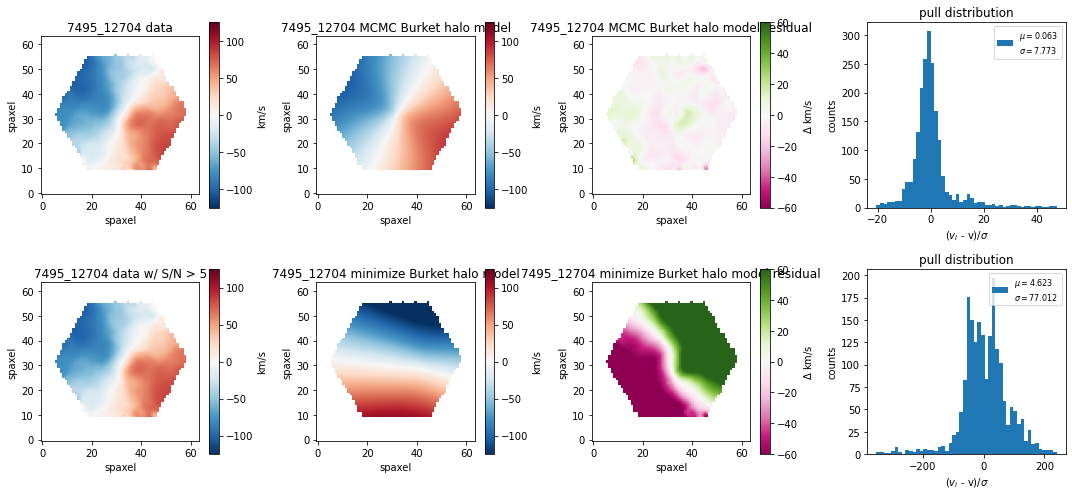

In [58]:
plt.figure(figsize=(15,7), tight_layout=True)


################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(241)

data_bur = plt.imshow(data_map, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-125, 
                      vmax=125)

plt.xlabel('spaxel')
plt.ylabel('spaxel')

cbar = plt.colorbar(data_iso)
cbar.set_label('km/s')

plt.title('7495_12704 data')
################################################################################


################################################################################
# Masked data
#-------------------------------------------------------------------------------
plt.subplot(245)

plt.imshow(vmasked, 
           origin='lower', 
           cmap='RdBu_r', 
           vmin=-125, 
           vmax=125)

plt.xlabel('spaxel')
plt.ylabel('spaxel')

cbar = plt.colorbar()
cbar.set_label('km/s')

plt.title('7495_12704 data w/ S/N > 5')
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(242)

bur_map_minimize = plt.imshow(mfitted_map_mcmc_bur, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-125, 
                              vmax=125)

plt.xlabel('spaxel')
plt.ylabel('spaxel')

cbar = plt.colorbar(bur_map_minimize)
cbar.set_label('km/s')

plt.title('7495_12704 MCMC Burket halo model')
################################################################################


################################################################################
# MCMC residual
#-------------------------------------------------------------------------------
plt.subplot(243)

residual_mc_bur = plt.imshow(residual_mcmc_bur, 
                             origin='lower', 
                             cmap='PiYG', 
                             vmin=-60, 
                             vmax=60)

plt.xlabel('spaxel')
plt.ylabel('spaxel')

cbar = plt.colorbar(residual_mc_bur)
cbar.set_label('$\Delta$ km/s')

plt.title('7495_12704 MCMC Burket halo model residual')
################################################################################


################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(246)

bur_map_minimize = plt.imshow(mfitted_map_minimize_bur, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-125, 
                              vmax=125)

plt.xlabel('spaxel')
plt.ylabel('spaxel')

cbar = plt.colorbar(bur_map_minimize)
cbar.set_label('km/s')

plt.title('7495_12704 minimize Burket halo model')
################################################################################


################################################################################
# minimize residual
#-------------------------------------------------------------------------------
plt.subplot(247)

residual_mini_bur = plt.imshow(residual_minimize_bur, 
                               origin='lower', 
                               cmap='PiYG', 
                               vmin=-60, 
                               vmax=60)

plt.xlabel('spaxel')
plt.ylabel('spaxel')

cbar = plt.colorbar(residual_mini_bur)
cbar.set_label('$\Delta$ km/s')

plt.title('7495_12704 minimize Burket halo model residual');
################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(244)

mean_mcmc_bur = ma.mean(dist_mcmc_bur)
sig_mcmc_bur = ma.std(dist_mcmc_bur)

dist_mcmc_bur = residual_mcmc_bur*np.sqrt(data_maps['ivar_masked'])

n_mcmc_bur, bins_mcmc_bur, patches_mcmc_bur = plt.hist(dist_mcmc_bur.compressed(),bins=50,
                                                      label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_bur, sig_mcmc_bur))

plt.xlabel('($v_i$ - v)/$\sigma$')
plt.ylabel('counts')
plt.title('pull distribution')
plt.legend(loc='upper right', fontsize=8)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(248)

mean_mini_bur = ma.mean(dist_minimize_bur)
sig_mini_bur = ma.std(dist_minimize_bur)

dist_minimize_bur = residual_minimize_bur*np.sqrt(data_maps['ivar_masked'])

n_mini_bur, bins_mini_bur, patches_mini_bur = plt.hist(dist_minimize_bur.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_bur, sig_mini_bur))

plt.xlabel('($v_i$ - v)/$\sigma$')
plt.ylabel('counts')
plt.title('pull distribution')
plt.legend(loc='upper right', fontsize=8)

################################################################################

print('mean of pull distribution mcmc NFW: ' + str(mean_mcmc_bur))
print('root mean square of pull distribution mcmc NFW: ' + str(sig_mcmc_bur))
print('mean of pull distribution minimize NFW: ' + str(mean_mini_bur))
print('root mean square of pull distribution minimize NFW: ' + str(sig_mini_bur))

In [59]:
nd_bur_mcmc = np.sum(~mfitted_map_mcmc_bur.mask)

chi2_bur_mcmc = ma.sum(data_maps['Ha_vel_ivar'] * (data_map - mfitted_map_mcmc_bur)**2)

chi2_bur_norm_mcmc = chi2_bur_mcmc / (nd_bur_mcmc - len(samples_mean_bur))
chi2_bur_norm_mcmc

60.69126310573908

In [60]:
nd_bur_minimize = np.sum(~mfitted_map_minimize_bur.mask)

chi2_bur_minimize = ma.sum(data_maps['Ha_vel_ivar'] * (data_map - mfitted_map_minimize_bur)**2)

chi2_bur_norm_minimize = chi2_bur_minimize / (nd_bur_minimize - len(mini_soln_bur))
chi2_bur_norm_minimize

5979.4326615299815

# Computing the loglikelihood

In [ ]:
logL_iso_mcmc = loglikelihood_iso_flat(samples_mean_iso, scale, gshape, vmasked.compressed(), ivar_masked.compressed(),Ha_vel_mask)
logL_iso_minimize = loglikelihood_iso_flat(np.array(mini_soln_iso), scale, gshape, vmasked.compressed(), ivar_masked.compressed(),Ha_vel_mask)
logL_NFW_mcmc = loglikelihood_NFW_flat(samples_mean_NFW, scale, gshape, vmasked.compressed(), ivar_masked.compressed(),Ha_vel_mask)
logL_NFW_minimize = loglikelihood_NFW_flat(np.array(mini_soln_NFW), scale, gshape, vmasked.compressed(), ivar_masked.compressed(),Ha_vel_mask)
logL_bur_mcmc = loglikelihood_bur_flat(samples_mean_bur, scale, gshape, vmasked.compressed(), ivar_masked.compressed(),Ha_vel_mask)
logL_bur_minimize = loglikelihood_bur_flat(np.array(mini_soln_bur), scale, gshape, vmasked.compressed(), ivar_masked.compressed(),Ha_vel_mask)

In [ ]:
logL_iso_mcmc

In [ ]:
logL_iso_minimize

In [ ]:
logL_NFW_mcmc

In [ ]:
logL_NFW_minimize

In [ ]:
logL_bur_mcmc

In [ ]:
logL_bur_minimize

In [ ]:
# log_Prob_minimize
logP_iso = logL_iso_minimize/(logL_iso_minimize + logL_NFW_minimize + logL_bur_minimize)
logP_NFW = logL_NFW_minimize/(logL_iso_minimize + logL_NFW_minimize + logL_bur_minimize)
logP_bur = logL_bur_minimize/(logL_iso_minimize + logL_NFW_minimize + logL_bur_minimize)

In [ ]:
logP_iso, logP_NFW, logP_bur

In [ ]:
# log_Prob_mcmc
logP_iso_mc = logL_iso_mcmc/(logL_iso_mcmc + logL_NFW_mcmc + logL_bur_mcmc)
logP_NFW_mc = logL_NFW_mcmc/(logL_iso_mcmc + logL_NFW_mcmc + logL_bur_mcmc)
logP_bur_mc = logL_bur_mcmc/(logL_iso_mcmc + logL_NFW_mcmc + logL_bur_mcmc)

In [ ]:
logP_iso_mc, logP_NFW_mc, logP_bur_mc